In [1]:
--------------------------------------------------------------------------------
-- Loading dataset to ram and sorting triplets
--------------------------------------------------------------------------------
-- Alfredo Canziani, Apr 15
--------------------------------------------------------------------------------

require 'image'
require 'sys'
require 'xlua'

-- set to 1 if using GPU
cuda = 1
if cuda == 1 then
    require 'cunn'
    require 'cutorch'
end

torch.setdefaulttensortype('torch.FloatTensor')

local dataset = {}
local imageSide = 120


-- Loading the dataset to RAM --------------------------------------------------
if paths.filep('dataset.t7') then
   io.write('Loading whole data set. Please wait...'); io.flush()
   dataset = torch.load('dataset.t7')
   print(' Done.')
else
   -- This script uses pubfig83.v1.tgz from http://vision.seas.harvard.edu/pubfig83/
   -- split in train and test folders
   -- each containing identities folders with images inside.
   -- Format:
   -- datasetRoot/{train,test}/<celebrityName>
   local datasetPaths = {}
   datasetPaths.base = 'pubfig83'

   for _, t in ipairs {'train', 'test'} do
      print('Building ' .. t .. 'ing data set')

      datasetPaths[t] = datasetPaths.base .. '/' .. t .. '/'
      local identities = sys.ls(datasetPaths[t]):split('\n')
        print(identities)
      local dataSize = tonumber(sys.execute('find ' .. datasetPaths[t] .. ' -iname "*.jpg"| wc -l'))
        print(dataSize)
      dataset[t] = {
         data = torch.Tensor(dataSize, 3, imageSide, imageSide),
         label = torch.Tensor(dataSize),
         index = torch.Tensor(#identities, 2),
      }

        
      local count = 0
      for id, idName in ipairs(identities) do
         dataset[t].index[id][1] = count + 1
         for _, img in ipairs(sys.ls(datasetPaths[t] .. idName):split('\n')) do
            count = count + 1
            xlua.progress(count, dataSize)
            -- print(count, paths.concat(datasetPaths[t], idName, img))
            local original = image.load(paths.concat(datasetPaths[t], idName, img))
            local h = original:size(2)
            local w = original:size(3)
            local m = math.min(h, w)
            local y = math.floor((h - m) / 2)
            local x = math.floor((w - m) / 2)
            
            dataset[t].data[count] = image.scale(
               original[{ {}, {y + 1, y + m}, {x + 1, x + m} }],
               imageSide, imageSide
           )
            dataset[t].label[count] = id
         end
         dataset[t].index[id][2] = count
         collectgarbage()
      end
   end

    trMean = dataset['train'].data:mean()
    trStd = dataset['train'].data:std()
    dataset['train'].data:add(-trMean)
    dataset['train'].data:div(trStd)
    dataset['test'].data:add(-trMean)
    dataset['test'].data:div(trStd) 
    
   io.write('Saving whole data set to disk...'); io.flush()
   torch.save('dataset.t7', dataset)
   print(' Done.')

    collectgarbage();
end


-- Private functions -----------------------------------------------------------
-- Training shuffle
local shuffle

-- New index table for t: train/test
local shuffleShuffle = function(t)
   shuffle = torch.randperm(dataset[t].data:size(1))
end


-- Get nb of (train and test) batches gives the batch size
local nbOfBatches = {}
local batchSize, pImgs
local getNbOfBatches = function(bS)
   batchSize = bS
   for _, t in ipairs {'train', 'test'} do
      nbOfBatches[t] = math.floor(dataset[t].data:size(1) / batchSize)
   end
   pImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   return nbOfBatches
end


-- Initialise the (train and test) embeddings
local embSize
local initEmbeddings = function(eS)
   embSize = eS
   for _, t in ipairs {'train', 'test'} do
      dataset[t].emb = torch.randn(dataset[t].data:size(1), embSize)
      dataset[t].emb = dataset[t].emb:cdiv(dataset[t].emb:norm(2, 2):repeatTensor(1, embSize))
        print(dataset[t])
   end
   print('Training and testing embeddings initialised with size ' .. embSize)
end


-- Get batch number nb for the t (train/test) dataset
-- <mode> by default is 'hard-neg' but can be set to 'soft-neg'
local pEmb
local getBatch = function(nb, t, mode, epoch)

   -- Main varialbles
   local aImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   local nImgs = torch.Tensor(batchSize, 3, imageSide, imageSide)
   local emb = torch.Tensor(batchSize, embSize)

   -- Auxiliary variables
   local labels = torch.Tensor(batchSize)
   local offset = batchSize * (nb - 1)
    
   -- Populating anchor and positive images batches
   for i = 1, batchSize do
      local loc = shuffle[i + offset] -- original location in data set
      print('off good')
      aImgs[i]  = dataset[t].data [loc]
      print('off good')
      emb[i]    = dataset[t].emb  [loc]
    print('off good')
      labels[i] = dataset[t].label[loc]
        print('off good')
      if mode ~= 'soft-neg2' then
         pImgs[i]  = dataset[t].data [math.random(
            dataset[t].index[labels[i]][1],
            dataset[t].index[labels[i]][2]
         )]
      end
   end
   
   -- Populating negative images batche
   local mode = mode or 'hard-neg'
   if mode == 'hard-neg' then
      for i = 1, batchSize do
         local diff = emb - emb[{ {i} }]:expandAs(emb)
         local norms = diff:norm(2, 2):squeeze()
         norms[labels:eq(labels[i])] = norms:max()
         local _, nIdx = norms:min(1) -- closest n-emb to a-emb
         nImgs[i] = aImgs[nIdx[1]]
      end
   elseif mode == 'soft-neg1' then
      -- do nothing
   elseif mode == 'soft-neg2' then
      for i = 1, batchSize do
         local diff = emb - emb[{ {i} }]:expandAs(emb)
         local norms = diff:norm(2, 2):squeeze()
         norms = norms - torch.Tensor(batchSize):fill((emb[i]-pEmb[i]):norm())
         norms[labels:eq(labels[i])] = norms:max()
         norms[norms:lt(0)] = norms:max()
         local _, nIdx = norms:min(1) -- closest n-emb to a-emb
         nImgs[i] = aImgs[nIdx[1]]
      end
   else error('Negative populating <mode> not recognised!')
   end

   return {aImgs, pImgs, nImgs}

end


-- Moves the batch to the GPU's RAM
local toCuda = function(batch)
   require 'cutorch'
   for i in ipairs(batch) do batch[i] = batch[i]:cuda() end
end


-- Saves the embeddings emb for the nb batch of t (train/test) data set
local saveEmb = function(emb, nb, t, posEmb)
   local offset = batchSize * (nb - 1)
   for i = 1, batchSize do
      dataset[t].emb[shuffle[i + offset]] = emb[i]:float()
   end
   if posEmb then pEmb = posEmb:float() end
end

local getDataset = function()
    
end

-- Public functions ------------------------------------------------------------
return {
   select         = shuffleShuffle,
   getNbOfBatches = getNbOfBatches,
   initEmbeddings = initEmbeddings,
   getBatch       = getBatch,
   toCuda         = toCuda,
   saveEmb        = saveEmb,
}

Loading whole data set. Please wait...

 Done.	


In [2]:
collectgarbage();

In [3]:
torch.manualSeed(0)
math.randomseed(0)

data = require 'data'

-- Shuffling training data
data.select('train') -- or 'test'

-- Initialise embeddings
embDim = 5
data.initEmbeddings(embDim)

-- Get train and test number of batches
batchDim = 10
trainBatches = data.getNbOfBatches(batchDim).train
print('trainBatches: ', trainBatches)

-- Get training batch nb 1
batch = data.getBatch(1, 'train')
print('batch = {aImg, pImg, nImg}: ', batch)

-- Send batch to cuda
--collectgarbage()
--data.toCuda(batch)
--print('Batch sent to GPU memory')

-- Saving embeddings
data.saveEmb(torch.randn(batchDim, embDim), 1, 'train')
print('Embedding saved for fast training')


Loading whole data set. Please wait...

 Done.	


Training and testing embeddings initialised with size 5	


trainBatches: 	5874	


batch = {aImg, pImg, nImg}: 	{
  1 : FloatTensor - size: 10x3x120x120
  2 : FloatTensor - size: 10x3x120x120
  3 : FloatTensor - size: 10x3x120x120
}
Embedding saved for fast training	


In [4]:
function printTriplets(batch)
    for i = 1, 10 do
            itorch.image({image.scale(batch[1][i], 48, 48), image.scale(batch[2][i], 48, 48), 
                image.scale(batch[3][i], 48, 48)})
    end
end

function morphBatch(dimension, batch)
--   1 : FloatTensor - size: 10x3x120x120
--   2 : FloatTensor - size: 10x3x120x120
--   3 : FloatTensor - size: 10x3x120x120
    
    temp = torch.Tensor(3,10,3,dimension,dimension)
    for i = 1, 10 do
            --downscale images to param dimension
            temp[1][i] = image.scale(batch[1][i], dimension, dimension)
            temp[2][i] = image.scale(batch[2][i], dimension, dimension)
            temp[3][i] = image.scale(batch[3][i], dimension, dimension)
            
            --rescale back to 120 for passing through network
            batch[1][i] = image.scale(temp[1][i], 120, 120)
            batch[2][i] = image.scale(temp[2][i], 120, 120)
            batch[3][i] = image.scale(temp[3][i], 120, 120)
    end
    return batch    
end

In [ ]:
meanStd = data.getMeanStd()
print(meanStd)

function preprocess(img)
    mean = meanStd[1]
    std = meanStd[2]
    for i = 1, 3 do
        img[{{i}, {}, {}}]:add(-mean[i])
        img[{{i}, {}, {}}]:div(std[i])
    end
end



{
  train : 
    {
      data : FloatTensor - size: 58746x3x120x120
      index : FloatTensor - size: 396x2
      emb : FloatTensor - size: 58746x5
      label : FloatTensor - size: 58746
    }
  test : 
    {
      data : FloatTensor - size: 19583x3x120x120
      index : FloatTensor - size: 134x2
      emb : FloatTensor - size: 19583x5
      label : FloatTensor - size: 19583
    }
}


batch = {aImg, pImg, nImg}: 	{
  1 : FloatTensor - size: 10x3x120x120
  2 : FloatTensor - size: 10x3x120x120
  3 : FloatTensor - size: 10x3x120x120
}


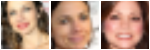

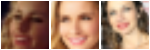

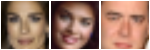

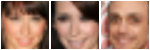

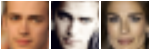

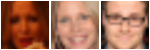

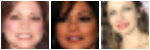

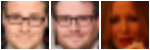

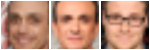

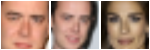

In [5]:

batch = data.getBatch(14, 'train')
print('batch = {aImg, pImg, nImg}: ', batch)
batch = morphBatch(20, batch)
printTriplets(batch)

In [6]:
require 'nn'
alexnet = torch.load('alexnetowtbn_epoch55_cpu.t7')

In [6]:
function createModel(alexnet)
--     local alexnet = createModelAlex()
    --convNet = createModelAlex()
    local alexnet = alexnet:clone()
    alexnet:evaluate()
    alexnet:get(2):remove()
    alexnet:get(2):remove()
    alexnet:get(2):remove()
    alexnet:get(2):remove()

    convNet = alexnet
    convNet:get(2):add(nn.View(4096))
    convNet:get(2):add(nn.Linear(4096, 128))
    convNet:get(2):add(nn.Normalize(2))
    convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(convNet)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    return parallel
end

function createModelTrip()
    embeddingSize = 3
    convNet = nn.Sequential()
    convNet:add(nn.SpatialConvolution(3, 8, 5, 5))
    convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
    convNet:add(nn.ReLU())
    convNet:add(nn.SpatialConvolution(8, 8, 5, 5))
    convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
    convNet:add(nn.ReLU())
    convNet:add(nn.View(8*2*2))
    convNet:add(nn.Linear(8*2*2, embeddingSize))
    convNet:add(nn.BatchNormalization(embeddingSize))
    
    convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(convNet)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    return parallel:cuda()
end


function computeSimilarity(x, y)
--     -- use L2 norm distance
--     diff = x - y
--     return diff:norm(2,1):pow(2)
--     local dist_sum = 0
--     for i = 1, 128 do
--         dist_sum += x[i] 
    return torch.dist(x, y)
end

In [8]:
imgDim = 224

local conv = nn.SpatialConvolutionMM
local relu = nn.ReLU
local mp = nn.SpatialMaxPooling

function createModelVGG()
   local net = nn.Sequential()

   net:add(conv(3, 64, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(64, 64, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(64, 128, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(128, 128, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(128, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(256, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))

   -- Validate shape with:
   -- net:add(nn.Reshape(25088))

   net:add(nn.View(25088))
   net:add(nn.Linear(25088, 4096))
   net:add(relu(true))

   net:add(nn.Linear(4096, 128))
   net:add(nn.Normalize(2))
    
    convNetPos = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(net)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)

    return parallel
end

function createModelAlex()
    local net = nn.Sequential()
    local fb1 = nn.Sequential()
    fb1:add(nn.SpatialConvolution(3,64,11,11,4,4,2,2))       -- 224 -> 55
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 55 ->  27
    fb1:add(nn.SpatialConvolution(64,192,5,5,1,1,2,2))       --  27 -> 27
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   --  27 ->  13
    fb1:add(nn.SpatialConvolution(192,384,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialConvolution(384,256,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialConvolution(256,256,3,3,1,1,1,1))      --  13 ->  13
    fb1:add(nn.ReLU(true))
    fb1:add(nn.SpatialMaxPooling(3,3,2,2))                   -- 13 -> 6

    local classifier = nn.Sequential()
    classifier:add(nn.View(256*6*6))
    classifier:add(nn.Dropout(0.5))
    classifier:add(nn.Linear(256*6*6, 4096))
    classifier:add(nn.Threshold(0, 1e-6))
    classifier:add(nn.Dropout(0.5))
--     classifier:add(nn.View(4096))
    classifier:add(nn.Linear(4096, 128))
    classifier:add(nn.Normalize(2))
    
    net:add(fb1)
    net:add(classifier)
    return net
end

In [9]:
require 'nn'

--Load the AlexNet model
meanStd = torch.load('alexnetowtbn_meanStd.t7')

-- Pre-process the image channel by channel.
function preprocess(im)
    local output_image = image.scale(im:clone(), 224, 224)
    for i = 1, 3 do -- channels
        output_image[{{i},{},{}}]:add(-meanStd.mean[i])
        output_image[{{i},{},{}}]:div(meanStd.std[i])
    end
    return output_image
end

In [10]:
require 'nn'
require 'TripletEmbedding'

local criterion = nn.TripletEmbeddingCriterion()
if cuda == 1 then
    criterion = criterion:cuda()
end

function trainModel(model, opt)
    if cuda == 1 then
        print("loading model onto GPU")
        model = model:cuda()
    end
    
    -- Get all the parameters (and gradients) of the model in a single vector.
    print("getting params")
    -- local params, gradParams = model:getParameters()
    local singleNet = model.modules[1]
    local opt = opt or {}
    local batchSize = opt.batchSize or 10  -- The bigger the batch size the most accurate the gradients.
    local numEpochs = opt.numEpochs or 3
    print("getting batches")
    local trainBatches = data.getNbOfBatches(batchSize).train
    print('trainBatches: ', trainBatches)
    local numEpochs = trainBatches
    -- Go over the training data this number of times.
    local inputs = data.getBatch(1, 'train')
     for epoch = 1, 10 do
        local sum_loss = 0
        local correct = 0
--         local inputs = data.getBatch(1, 'train')

        -- Run over the training set samples.
        -- set internal var Train=True so that layers like Dropout behave correctly. Also see :evaluate()
        
--         model:training()
        
        -- 2. Perform the forward pass (prediction mode).
        --:view(1, 3, 224, 224)
        -- Ancore training samples/images
        local imageDim = 20
        local batch = 10
        aImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
        pImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
        -- Negative training samples/images
        nImgs = torch.rand(batch, 3, imageDim, imageDim):cuda()
--         print(nImgs)
        
        
        wrapperTotal = torch.Tensor(3, 10, 3, imageDim, imageDim)
        
        for apn = 1, 3 do
            for batchN = 1, batchSize do
                wrapper = torch.Tensor(1, 3, imageDim, imageDim)
                wrapper[1] = image.scale(inputs[apn][batchN], imageDim, imageDim)
                wrapperTotal[apn][batchSize] = wrapper
            end
        end
--         wrapperTotal = {inputs[1], inputs[2], inputs[3]}
--         wrapperTotal = inputs
        
--         print(image.scale(inputs[1], imageDim, imageDim))
--         print('haha')
        if cuda == 1 then
            wrapperTotal = wrapperTotal:cuda()
        end
--         print(inputs)
--         print(inputs:size())
--         print({wrapperTotal[1], wrapperTotal[2], wrapperTotal[3]})
--         local predictions = model:forward({wrapperTotal[1], wrapperTotal[2], wrapperTotal[3]})
        print({aImgs, pImgs, nImgs})
        local predictions = model:forward({aImgs, pImgs, nImgs})
--         print('haha1')
        print(predictions)
        --print("passed")
        -- 3. Evaluate results.
        --for i = 1, predictions:size(1) do
        --    local _, predicted_label = predictions[i]:max(1)
        --    if predicted_label[1] == labels[i] then correct = correct + 1 end
        --end
        local sum_loss = sum_loss + criterion:forward(predictions)
--         print("passed stage 2")
        -- TODO: need to figure out how to change this to accomandate the BCECriterion
        -- 4. Perform the backward pass (compute derivatives).
        -- This zeroes-out all the parameters inside the model pointed by variable params.
        
--          print("passed stage 3")
        -- This internally computes the gradients with respect to the parameters pointed by gradParams.
        local gradPredictions = criterion:backward(predictions)
        model:zeroGradParameters()
--          print("passed stage 4")
        --{wrapper, wrapper2, wrapper3}
        model:backward({aImgs, pImgs, nImgs}, gradPredictions)
        model:updateParameters(0.01)
--          print("passed stage 5")
         -- 5. Perform the SGD update.
        if epoch % 100 == 0 then
            model:updateParameters(0.01)
        end
        
        if epoch % 10 == 0 then  -- Print this every 10 epochs.
            print(('train epoch=%d, avg-loss=%.6f')
                :format(epoch, sum_loss / epoch))
        end

        -- Run over the validation set for evaluation.
        print(epoch)
        itorch.image({image.scale(inputs[1][1], 48, 48), image.scale(inputs[2][1], 48, 48), 
                image.scale(inputs[3][1], 48, 48)})
        
        if epoch == 1 then
            print(predictions[1][1])
        end
        
        local ap = computeSimilarity(predictions[1][1], predictions[2][1])
        local an = computeSimilarity(predictions[1][1], predictions[3][1])
        print(('\na-->p %.4f'):format(ap))
        print(('\na-->n %.4f'):format(an))
        --print(('\nvalidation accuracy at epoch = %d is %.4f'):format(epoch, validation_accuracy))
    end
end

In [11]:
--model = createModelTrip()


In [12]:
--trainModel(model:clone(), {})

In [7]:
--------------------------------------------------------------------------------
-- Fresh embedding training example
--------------------------------------------------------------------------------
-- Alfredo Canziani, Apr 15
--------------------------------------------------------------------------------

-- package.path = "../?.lua;" .. package.path

require 'nn'
require 'TripletEmbedding'
colour = require 'trepl.colorize'
local b = colour.blue

torch.manualSeed(0)

local learningRate = 0.1
local batchSize = 10
local embeddingSize = 3
local imgSize = 120
downSize = 20
local trainBatches = data.getNbOfBatches(batchSize).train
print('trainBatches = ' .. trainBatches)




-- Network definition
-- convNet = nn.Sequential()
-- convNet:add(nn.SpatialConvolution(3, 8, 5, 5))
-- convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
-- convNet:add(nn.ReLU())
-- convNet:add(nn.SpatialConvolution(8, 8, 5, 5))
-- convNet:add(nn.SpatialMaxPooling(2, 2, 2, 2))
-- convNet:add(nn.ReLU())
-- convNet:add(nn.View(8*2*2))
-- convNet:add(nn.Linear(8*2*2, embeddingSize))
-- convNet:add(nn.BatchNormalization(embeddingSize))

-- convNetPos = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')
-- convNetNeg = convNet:clone('weight', 'bias', 'gradWeight', 'gradBias')

-- -- Parallel container
-- parallel = nn.ParallelTable()
-- parallel:add(convNet)
-- parallel:add(convNetPos)
-- parallel:add(convNetNeg)
-- parallel = parallel:cuda()

local conv = nn.SpatialConvolutionMM
local sbn = nn.SpatialBatchNormalization
local relu = nn.ReLU
local mp = nn.SpatialMaxPooling

 local net = nn.Sequential()

   net:add(conv(3, 64, 3,3, 1,1, 1,1))
   net:add(sbn(64))
   net:add(relu(true))
   net:add(conv(64, 64, 3,3, 1,1, 1,1))
   net:add(sbn(64))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(64, 128, 3,3, 1,1, 1,1))
   net:add(sbn(128))
   net:add(relu(true))
   net:add(conv(128, 128, 3,3, 1,1, 1,1))
   net:add(sbn(128))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(128, 256, 3,3, 1,1, 1,1))
   net:add(sbn(256))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(sbn(256))
   net:add(relu(true))
   net:add(conv(256, 256, 3,3, 1,1, 1,1))
   net:add(sbn(256))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(256, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(conv(512, 512, 3,3, 1,1, 1,1))
   net:add(sbn(512))
   net:add(relu(true))
   net:add(mp(2,2, 2,2))

   -- Validate shape with:
   net:add(nn.Reshape(4608)) --changed from 4608

   net:add(nn.View(4608))  --changed from 4608
   net:add(nn.Linear(4608, 1024))  --same, from 4608
   net:add(relu(true))

   net:add(nn.Linear(1024, 64))
   net:add(nn.Normalize(2))
    
    convNetPos = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    convNetNeg = net:clone('weight', 'bias', 'gradWeight', 'gradBias')
    -- Parallel container
    parallel = nn.ParallelTable()
    parallel:add(net)
    parallel:add(convNetPos)
    parallel:add(convNetNeg)
    parallel = parallel:cuda()

-- Cost function

loss = nn.TripletEmbeddingCriterion()
loss = loss:cuda()
local sumErr = 0
local sumMeanP = 0
local sumMeanN = 0
--trainBatches = trainBatches/2
local printVal = trainBatches/3
local epochsTotal = 20
local file = io.open("stats_" .. tostring(downSize) .. "-->" .. tostring(imgSize) .. "_" .. tostring(epochsTotal) .. ".txt", "a")

for epoch = 1, epochsTotal do
    for i = 1, trainBatches do
        --print(i .. " " .. trainBatches)
        local inputs = data.getBatch(i, 'train')
        inputs = morphBatch(downSize, inputs)

        local resize_inputs = {torch.Tensor(batchSize, 3, imgSize, imgSize),
            torch.Tensor(batchSize, 3, imgSize, imgSize),
            torch.Tensor(batchSize, 3, imgSize, imgSize)}

        for apn = 1, 3 do
            for imgN = 1, batchSize do
                resize_inputs[apn][imgN] = image.scale(inputs[apn][imgN], imgSize, imgSize)
            end
        end
        --print('pass')
        aImgs = resize_inputs[1]
        -- Positive training samples/images
        pImgs = resize_inputs[2]
        -- Negative training samples/images
        nImgs = resize_inputs[3]
        
        local inputs = {aImgs, pImgs, nImgs}
       predict = parallel:forward({aImgs:cuda(), pImgs:cuda(), nImgs:cuda()})
        --print(inputs)
       err = loss:forward(predict)
       sumErr = sumErr + err
       errGrad = loss:backward(predict)
       parallel:zeroGradParameters()
       parallel:backward({aImgs:cuda(), pImgs:cuda(), nImgs:cuda()}, errGrad)

       parallel:updateParameters(learningRate)
        
        local mean_ap = 0
        local mean_an = 0
        for j = 1, batchSize do
            local ap = computeSimilarity(predict[1][j], predict[2][j])
            local an = computeSimilarity(predict[1][j], predict[3][j])
            mean_ap = mean_ap + ap
            mean_an = mean_an + an
        end
        mean_ap = mean_ap / batchSize
        mean_an = mean_an / batchSize
        sumMeanP = sumMeanP + mean_ap
        sumMeanN = sumMeanN + mean_an

        if i==trainBatches/3 or i==2*(trainBatches/3) or i==trainBatches then  --  i%printVal == 0 then
            print(colour.green('Epoch ' .. epoch))
            print(('\na-->p %.6f'):format(sumMeanP/printVal))
            print(('\na-->n %.6f'):format(sumMeanN/printVal))
            print(colour.red('loss: '), ('%.6f'):format(sumErr/printVal))
            file:write(epoch)
            file:write(',')
            file:write(('%.6f,'):format(sumMeanP/printVal))
            file:write(('%.6f,'):format(sumMeanN/printVal))
            file:write(('%.6f\n'):format(sumErr/printVal))
            file:flush()
            sumMeanP = 0
            sumMeanN = 0
            sumErr = 0
        end
    end
    
     if epoch == (epochsTotal/10)*2 then
            learningRate = .01
        elseif epoch == (epochsTotal/10)*4 then
            learningRate = .001
        elseif epoch == (epochsTotal/10)*6 then
            learningRate = .0001
        elseif epoch == (epochsTotal/10)*8 then
            learningRate = .00001
        end
end

file:close()
local filename = "VGG_small_" .. tostring(downSize) .. "-->" .. tostring(imgSize) .. "_" .. tostring(epochsTotal) .. ".t7"
torch.save(tostring(filename), parallel)

trainBatches = 5874	


Epoch 1	

a-->p 0.184699	

a-->n 0.221026	
loss: 	0.186081	


Epoch 1	

a-->p 0.284711	

a-->n 0.374431	
loss: 	0.159679	


Epoch 1	

a-->p 0.321042	

a-->n 0.448960	
loss: 	0.140649	


Epoch 2	

a-->p 0.327681	

a-->n 0.508791	
loss: 	0.119628	


Epoch 2	

a-->p 0.321152	

a-->n 0.531889	
loss: 	0.111085	


Epoch 2	

a-->p 0.311963	

a-->n 0.558566	
loss: 	0.100258	


Epoch 3	

a-->p 0.316575	

a-->n 0.585014	
loss: 	0.094322	


Epoch 3	

a-->p 0.324041	

a-->n 0.598449	
loss: 	0.093117	


Epoch 3	

a-->p 0.328151	

a-->n 0.625816	
loss: 	0.084694	


Epoch 4	

a-->p 0.338075	

a-->n 0.651463	
loss: 	0.080443	


Epoch 4	

a-->p 0.336469	

a-->n 0.656332	
loss: 	0.079987	


Epoch 4	

a-->p 0.346583	

a-->n 0.690797	
loss: 	0.074511	


Epoch 5	

a-->p 0.341720	

a-->n 0.704573	
loss: 	0.068413	


Epoch 5	

a-->p 0.349228	

a-->n 0.724424	
loss: 	0.065877	


Epoch 5	

a-->p 0.349772	

a-->n 0.751923	
loss: 	0.060111	


Epoch 6	

a-->p 0.353001	

a-->n 0.746236	
loss: 	0.063019	


Epoch 6	

a-->p 0.351842	

a-->n 0.739763	
loss: 	0.063160	


Epoch 6	

a-->p 0.355641	

a-->n 0.765538	
loss: 	0.058255	


Epoch 7	

a-->p 0.357756	

a-->n 0.763566	
loss: 	0.060182	


Epoch 7	

a-->p 0.357562	

a-->n 0.762188	
loss: 	0.060285	


Epoch 7	

a-->p 0.359608	

a-->n 0.777279	
loss: 	0.056370	


Epoch 8	

a-->p 0.360529	

a-->n 0.774181	
loss: 	0.058221	


Epoch 8	

a-->p 0.363307	

a-->n 0.779799	


loss: 	0.058228	


Epoch 8	

a-->p 0.364167	

a-->n 0.792795	
loss: 	0.054717	


Epoch 9	

a-->p 0.368176	

a-->n 0.790973	
loss: 	0.055981	


Epoch 9	

a-->p 0.367321	

a-->n 0.786827	
loss: 	0.055803	


Epoch 9	

a-->p 0.365035	

a-->n 0.800838	
loss: 	0.051390	


Epoch 10	

a-->p 0.368744	

a-->n 0.796221	
loss: 	0.055749	


Epoch 10	

a-->p 0.366486	

a-->n 0.796258	
loss: 	0.054525	


Epoch 10	

a-->p 0.365854	

a-->n 0.805162	
loss: 	0.051379	


Epoch 11	

a-->p 0.368744	

a-->n 0.796888	
loss: 	0.054687	


Epoch 11	

a-->p 0.367848	

a-->n 0.796535	
loss: 	0.052932	


Epoch 11	

a-->p 0.368130	

a-->n 0.810078	
loss: 	0.051611	


Epoch 12	

a-->p 0.370427	

a-->n 0.801227	
loss: 	0.055629	


Epoch 12	

a-->p 0.368444	

a-->n 0.798861	
loss: 	0.053360	


Epoch 12	

a-->p 0.367688	

a-->n 0.810266	
loss: 	0.051110	


Epoch 13	

a-->p 0.372407	

a-->n 0.806393	
loss: 	0.054419	


Epoch 13	

a-->p 0.371456	

a-->n 0.805596	
loss: 	0.053464	


Epoch 13	

a-->p 0.369415	

a-->n 0.814504	
loss: 	0.049761	


Epoch 14	

a-->p 0.372215	

a-->n 0.806204	
loss: 	0.055300	


Epoch 14	

a-->p 0.371294	

a-->n 0.804887	
loss: 	0.053709	


Epoch 14	

a-->p 0.369275	

a-->n 0.813584	
loss: 	0.049954	


Epoch 15	

a-->p 0.372030	

a-->n 0.806040	
loss: 	0.054916	


Epoch 15	

a-->p 0.371773	

a-->n 0.805110	
loss: 	0.053011	


Epoch 15	

a-->p 0.372420	

a-->n 0.813885	
loss: 	0.051144	


Epoch 16	

a-->p 0.370926	

a-->n 0.805913	
loss: 	0.053377	


Epoch 16	

a-->p 0.370416	

a-->n 0.805358	
loss: 	0.053132	


Epoch 16	

a-->p 0.368786	

a-->n 0.814054	
loss: 	0.049980	


Epoch 17	

a-->p 0.370789	

a-->n 0.806639	
loss: 	0.054605	


Epoch 17	

a-->p 0.372456	

a-->n 0.806262	
loss: 	0.053010	


Epoch 17	

a-->p 0.368601	

a-->n 0.814797	
loss: 	0.050009	


Epoch 18	

a-->p 0.371309	



a-->n 0.806740	
loss: 	0.054271	


Epoch 18	

a-->p 0.369552	

a-->n 0.806306	
loss: 	0.053116	


Epoch 18	

a-->p 0.367851	

a-->n 0.814862	
loss: 	0.049775	


Epoch 19	

a-->p 0.372778	

a-->n 0.806769	
loss: 	0.054197	


Epoch 19	

a-->p 0.372729	

a-->n 0.806388	
loss: 	0.052620	


Epoch 19	

a-->p 0.370018	

a-->n 0.814913	
loss: 	0.050170	


Epoch 20	



a-->p 0.370309	

a-->n 0.806795	
loss: 	0.054625	


Epoch 20	

a-->p 0.373754	

a-->n 0.806314	
loss: 	0.053448	


Epoch 20	

a-->p 0.368579	

a-->n 0.814861	
loss: 	0.050352	


In [7]:
require 'nn'
torch.setdefaulttensortype('torch.FloatTensor')

model = torch.load('VGG_small_120_20.t7')
model:evaluate()
model_float = model:float()

In [8]:
submodel1 = model:get(1)
submodel2 = model:get(2)
mod1 = nn.ParallelTable()
mod1:add(submodel1)
mod1:add(submodel1)
submodel3 = model:get(3)


--submodel:training()

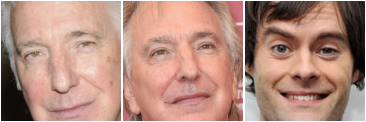

0.019023080980105	
0.66767823443563	


In [9]:
img1 = image.load('us1.jpg', 3, 'float')
img2 = image.load('us2.jpg', 3, 'float')
img3 = image.load('us3.jpg', 3, 'float')
input_image1 = image.scale(img1, 120, 120)
input_image2 = image.scale(img2, 120, 120)
input_image3 = image.scale(img3, 120, 120)
itorch.image({input_image1, input_image2, input_image3})
wrapper1 = torch.Tensor(1,3,120,120)
wrapper1[1] = input_image1
wrapper2 = torch.Tensor(1,3,120,120)
wrapper2[1] = input_image2
wrapper3 = torch.Tensor(1,3,120,120)
wrapper3[1] = input_image3
-- print(wrapper:size())
-- predictions = model:forward({wrapper:cuda(), wrapper:cuda(), wrapper:cuda()})
-- print(computeSimilarity(predictions[1], predictions[2]))
-- print(computeSimilarity(predictions[1], predictions[3]))
-- predictions = model:forward({wrapper1, wrapper2, wrapper3})
-- print(computeSimilarity(predictions[1], predictions[2]))
-- print(computeSimilarity(predictions[1], predictions[3])) 
prediction1 = submodel1:forward(wrapper1)
prediction1 = prediction1:clone()
prediction2 = submodel1:forward(wrapper2)
prediction2 = prediction2:clone()
prediction3 = submodel1:forward(wrapper3)
prediction3 = prediction3:clone()
print(computeSimilarity(prediction1, prediction2))
print(computeSimilarity(prediction1, prediction3))

-- predictions = mod1:forward({wrapper1, wrapper2})
-- print(computeSimilarity(predictions[1], predictions[2]))



In [10]:

-- collectgarbage();
-- model = torch.load('VGG_small_20.t7')
-- model = model:get(1)
torch.save("VGG_small_float_20_athrid.t7", submodel1)

In [11]:
model_athird = torch.load('VGG_small_float_20_athrid.t7')
model_athird:evaluate()
prediction1 = model_athird:forward(wrapper1)
prediction1 = prediction1:clone()
prediction2 = model_athird:forward(wrapper2)
prediction2 = prediction2:clone()
prediction3 = model_athird:forward(wrapper3)
prediction3 = prediction3:clone()
print(computeSimilarity(prediction1, prediction2))
print(computeSimilarity(prediction1, prediction3))

0.019023080980105	
0.66767823443563	


In [12]:
collectgarbage()
require 'cunn'
require 'cutorch'
parallel = torch.load('VGG_small_120_20.t7')



In [13]:
batchSize = 10
trainBatches = data.getNbOfBatches(batchSize).train
print(trainBatches)

function printTriplet(batch, num)
        itorch.image({image.scale(batch[1][num], 48, 48), image.scale(batch[2][num], 48, 48), 
            image.scale(batch[3][num], 48, 48)})

end

5874	


In [ ]:
--APANDA SECTION
parallel = parallel:cuda()
falsePos = 0
correct = 0
sumDiff = 0

imgSize = 120
local file = io.open("apAndAn" .. tostring(trainBatches) .. "_DS_" .. tostring(downSize) .. "-->" .. tostring(imgSize) .. ".txt", "a")
for i = 1, trainBatches do
        --print(i .. " " .. trainBatches)
        local inputs = data.getBatch(i, 'train')
        local resize_inputs = {torch.Tensor(batchSize, 3, imgSize, imgSize),
            torch.Tensor(batchSize, 3, imgSize, imgSize),
            torch.Tensor(batchSize, 3, imgSize, imgSize)}

        for apn = 1, 3 do
            for imgN = 1, batchSize do
                resize_inputs[apn][imgN] = image.scale(inputs[apn][imgN], imgSize, imgSize)
            end
        end
        --print('pass')
        aImgs = resize_inputs[1]
        -- Positive training samples/images
        pImgs = resize_inputs[2]
        -- Negative training samples/images
        nImgs = resize_inputs[3]
        
        local inputs = {aImgs, pImgs, nImgs}
        predict = parallel:forward({aImgs:cuda(), pImgs:cuda(), nImgs:cuda()})
       
        for batchN = 1, batchSize do
            local ap = computeSimilarity(predict[1][batchN], predict[2][batchN])
            local an = computeSimilarity(predict[1][batchN], predict[3][batchN])
            if (an - ap < 0) then
                falsePos = falsePos + 1
                sumDiff = sumDiff + (ap - an)
                print(('%.6f,'):format(ap) .. ('%.6f\n'):format(an))
                printTriplet(inputs, batchN)
            else
                correct = correct + 1
            end
            file:write(('%.6f,'):format(ap))
            file:write(('%.6f\n'):format(an))
            file:flush()
        end

end

avgDiff = sumDiff/falsePos
print("Total correct: " .. correct)
print("Total false positives: " .. falsePos)
print("Average false positive difference: " .. avgDiff)

file:write("Correct: " .. correct)
file:write("\nIncorrect: " .. falsePos)
file:write("\nAvg FP difference: " .. avgDiff)

file:close()

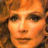

1 3	


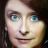

1 7	


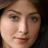

1 8	


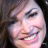

1 9	


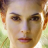

2 7	


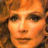

3 4	


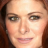

3 7	


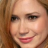

4 1	


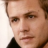

4 4	


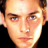

4 7	


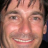

4 9	


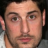

5 7	


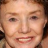

5 10	


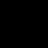

6 8	


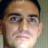

7 2	


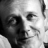

7 5	


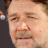

7 7	


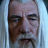

8 2	


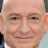

8 5	


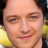

8 7	


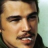

8 10	


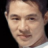

9 6	


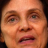

9 10	


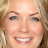

10 7	


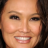

11 2	


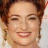

11 7	


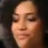

12 4	


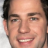

12 5	


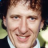

12 7	


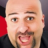

12 8	


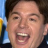

12 9	


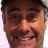

13 4	


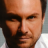

13 7	


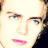

14 7	


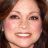

15 2	


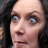

15 4	


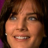

15 7	


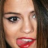

15 10	


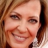

16 1	


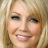

16 4	


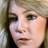

16 7	


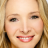

16 9	


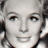

17 3	


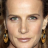

17 7	


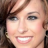

18 1	


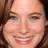

18 7	


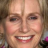

18 8	


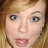

19 6	


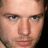

19 8	


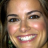

20 1	


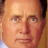

20 7	


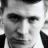

20 9	


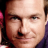

20 10	


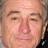

21 2	


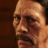

21 7	


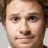

21 9	


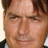

21 10	


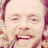

22 2	


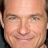

22 3	


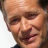

22 7	


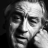

23 4	


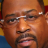

23 6	


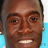

23 7	


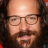

24 2	


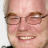

24 7	


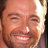

24 8	


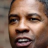

25 3	


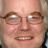

25 6	


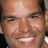

25 7	


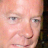

26 6	


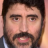

26 7	


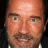

26 8	


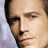

26 9	


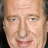

27 3	


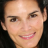

27 7	


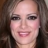

27 10	


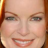

28 5	


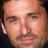

28 6	


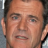

28 7	


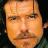

29 7	


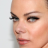

29 10	


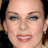

30 3	


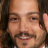

30 4	


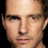

30 5	


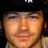

30 7	


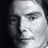

30 9	


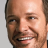

30 10	


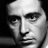

31 5	


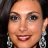

31 7	


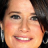

32 4	


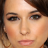

32 7	


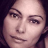

32 10	


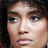

33 3	


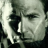

33 7	


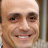

34 4	


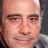

34 7	


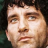

35 1	


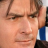

35 6	


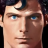

35 7	


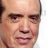

35 10	


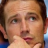

36 5	


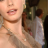

36 6	


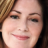

36 7	


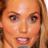

36 8	


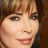

37 5	


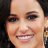

37 7	


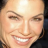

38 6	


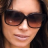

38 7	


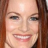

38 8	


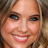

39 7	


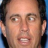

40 2	


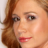

40 7	


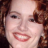

40 8	


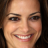

40 9	


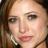

41 5	


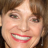

41 6	


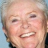

41 7	


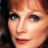

42 5	


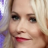

42 7	


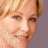

43 7	


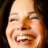

43 10	


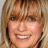

44 7	


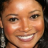

45 7	


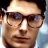

45 9	


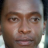

46 3	


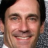

46 7	


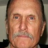

46 8	


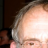

46 9	


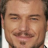

46 10	


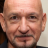

47 3	


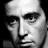

48 1	


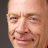

48 4	


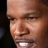

48 5	


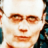

48 7	


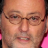

48 9	


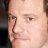

49 4	


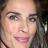

49 7	


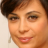

49 10	


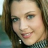

50 7	


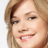

50 10	


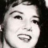

51 7	


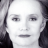

52 1	


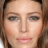

52 3	


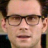

52 8	


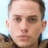

52 10	


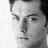

53 3	


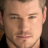

53 6	


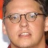

54 4	


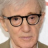

54 5	


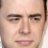

55 4	


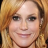

55 7	


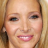

56 7	


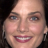

56 10	


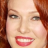

57 1	


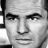

57 4	


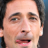

58 6	


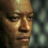

58 7	


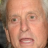

59 2	


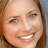

59 6	


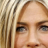

59 7	


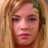

59 8	


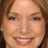

60 1	


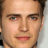

60 5	


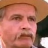

60 10	


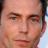

61 2	


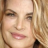

61 3	


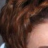

61 7	


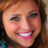

62 3	


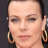

62 4	


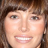

62 5	


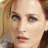

62 7	


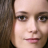

62 10	


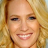

63 7	


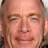

64 1	


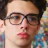

64 5	


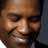

64 9	


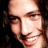

65 1	


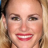

65 2	


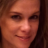

65 7	


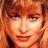

65 10	


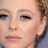

66 7	


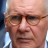

67 1	


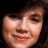

67 3	


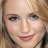

67 4	


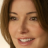

67 7	


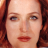

67 8	


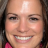

67 9	


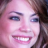

68 1	


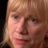

68 4	


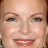

68 5	


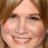

68 6	


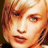

68 7	


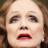

69 6	


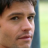

69 7	


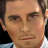

70 7	


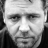

70 10	


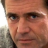

71 8	


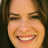

71 10	


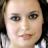

72 4	


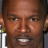

72 5	


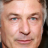

72 7	


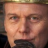

73 7	


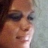

73 8	


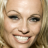

74 1	


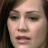

74 2	


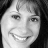

74 3	


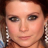

74 5	


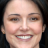

74 7	


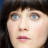

75 7	


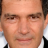

75 9	


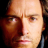

76 5	


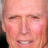

76 7	


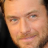

77 2	


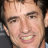

77 6	


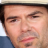

77 7	


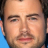

77 9	


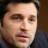

78 2	


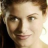

78 7	


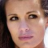

79 1	


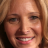

79 7	


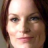

79 9	


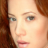

80 7	


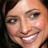

80 8	


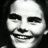

80 9	


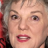

81 2	


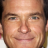

81 6	


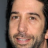

81 7	


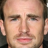

81 10	


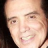

82 5	


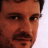

82 7	


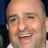

82 9	


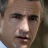

83 6	


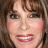

83 7	


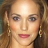

83 10	


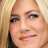

84 1	


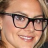

84 2	


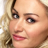

84 5	


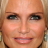

84 7	


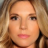

84 10	


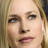

85 2	


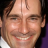

85 7	


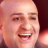

85 8	


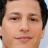

85 9	


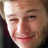

86 7	


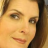

86 10	


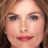

87 2	


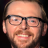

87 7	


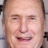

88 1	


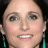

88 5	


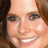

88 7	


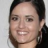

88 8	


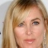

89 1	


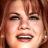

89 2	


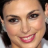

89 7	


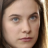

89 9	


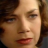

90 4	


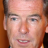

90 5	


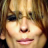

90 6	


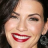

90 7	


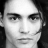

91 7	


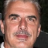

92 6	


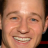

92 7	


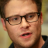

93 5	


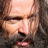

93 7	


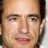

94 1	


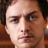

94 7	


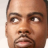

94 9	


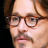

95 7	


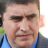

96 7	


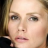

96 10	


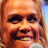

97 4	


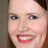

97 5	


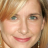

97 7	


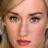

98 1	


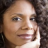

98 6	


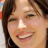

98 7	


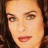

99 6	


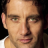

99 7	


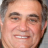

99 8	


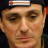

100 2	


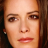

100 7	


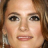

101 5	


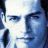

101 7	


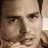

102 2	


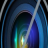

102 5	


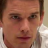

103 3	


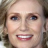

103 5	


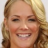

103 7	


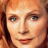

103 9	


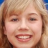

103 10	


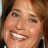

104 7	


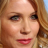

104 8	


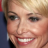

105 9	


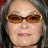

106 2	


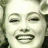

106 4	


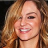

106 7	


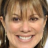

107 4	


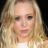

107 5	


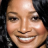

107 7	


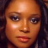

108 2	

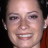

108 4	


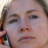

108 7	


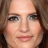

109 3	


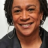

109 7	


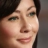

109 9	


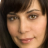

109 10	


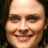

110 1	


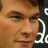

110 4	


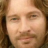

110 6	


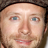

110 7	


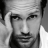

111 1	


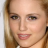

111 7	


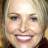

112 7	


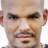

113 2	


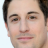

113 4	


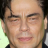

113 7	


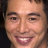

113 10	


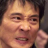

114 2	


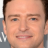

114 4	


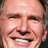

114 5	


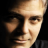

114 7	


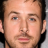

114 8	


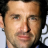

114 10	


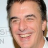

115 1	


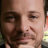

115 3	


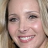

115 7	


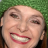

116 1	


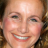

116 6	


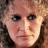

116 7	


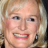

117 1	


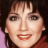

117 4	


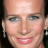

117 6	


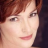

118 1	


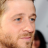

118 7	


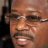

118 8	


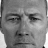

119 4	


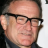

119 7	


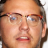

120 2	


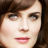

120 4	


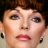

120 7	


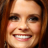

121 4	


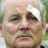

121 7	


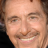

122 4	


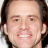

122 7	


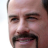

123 3	


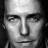

123 7	


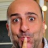

124 3	


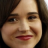

124 5	


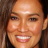

124 7	


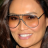

125 2	


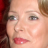

125 7	


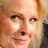

126 1	


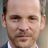

126 2	


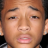

126 4	


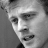

126 6	


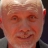

126 10	


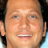

127 2	


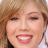

127 3	


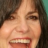

128 1	


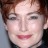

128 7	


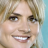

129 5	


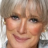

129 7	


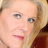

129 8	


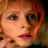

130 6	


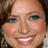

130 7	


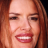

131 1	


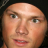

131 7	


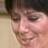

131 10	


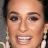

132 5	


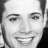

132 6	


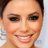

132 9	


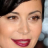

133 4	


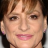

133 5	


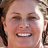

133 7	


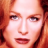

133 10	


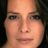

134 2	


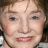

134 7	


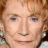

134 8	


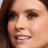

135 7	


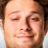

135 8	


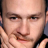

135 10	


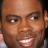

136 7	


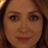

136 8	


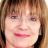

136 10	


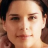

137 1	


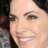

137 2	


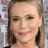

137 6	


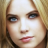

137 8	


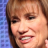

137 10	


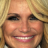

138 4	


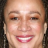

138 6	


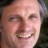

138 7	


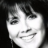

139 6	


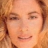

139 7	


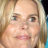

140 3	


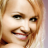

140 4	


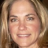

140 7	


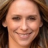

141 2	


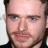

141 4	


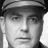

141 7	


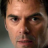

142 2	


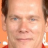

142 3	


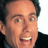

142 5	


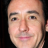

142 6	


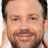

142 7	


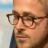

143 7	


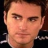

144 3	


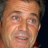

144 7	


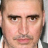

145 4	


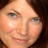

145 7	


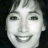

146 7	


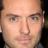

147 7	


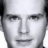

148 3	


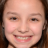

148 6	


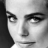

148 7	


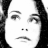

148 8	


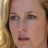

149 6	


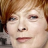

149 7	


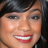

150 7	


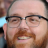

150 8	


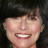

150 9	


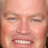

151 7	


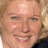

151 10	


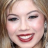

152 1	


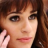

152 5	


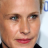

152 7	


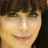

152 10	


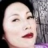

153 4	


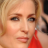

153 6	


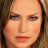

153 7	


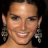

154 7	


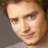

155 3	


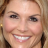

155 4	


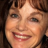

155 7	


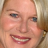

156 7	


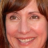

156 8	


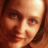

156 9	


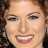

157 7	


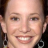

157 8	


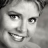

157 10	


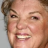

158 3	


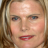

158 7	


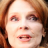

159 7	


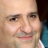

160 3	


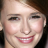

160 5	


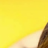

160 7	


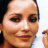

161 4	


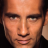

161 6	


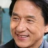

161 7	


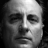

162 5	


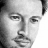

162 7	


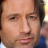

163 1	


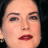

163 2	


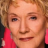

163 3	


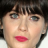

163 9	


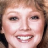

164 2	


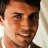

164 7	


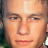

165 4	


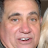

165 5	


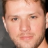

165 7	


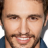

166 7	


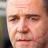

166 10	


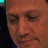

167 2	


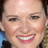

167 7	


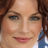

168 7	


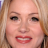

168 8	


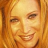

169 3	


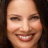

169 4	


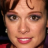

169 5	


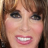

169 7	


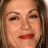

170 3	


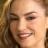

170 7	


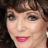

171 1	


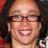

171 3	


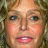

171 9	


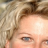

171 10	


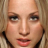

172 2	


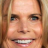

172 5	


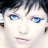

172 7	


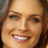

172 8	


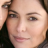

172 10	


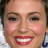

173 3	


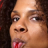

173 6	


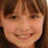

173 7	


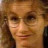

173 8	


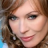

174 3	


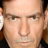

174 7	


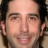

175 7	


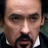

175 9	


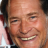

176 1	


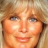

176 2	


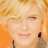

176 7	


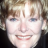

176 10	


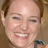

177 6	


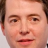

177 7	


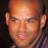

178 4	


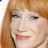

178 7	


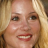

178 9	


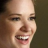

179 1	


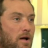

179 5	


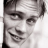

179 7	


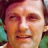

179 8	


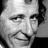

180 4	


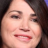

180 7	


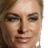

180 8	


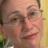

181 1	


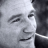

181 7	


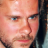

181 9	


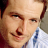

182 7	


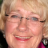

183 7	


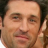

183 9	


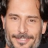

184 1	


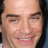

184 7	


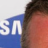

185 4	


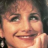

185 7	


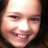

185 10	


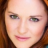

186 7	


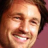

186 8	


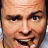

186 9	


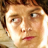

187 5	


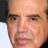

187 7	


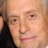

187 8	


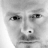

187 10	


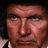

188 2	


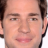

188 7	


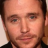

188 8	


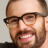

189 7	


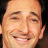

189 10	


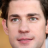

190 1	


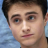

190 7	


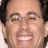

191 7	


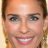

191 8	


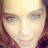

192 7	


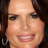

192 9	


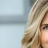

193 4	


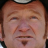

193 7	


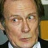

193 8	


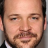

194 5	


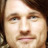

194 6	


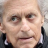

195 4	


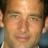

195 5	


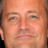

195 7	


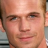

196 1	


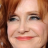

196 3	


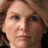

196 7	


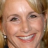

197 3	


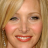

197 6	


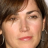

197 7	


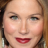

197 9	


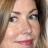

198 4	


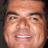

198 6	


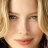

198 7	


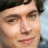

199 3	


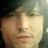

199 5	


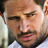

199 6	


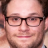

199 7	


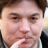

200 7	


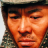

201 5	


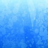

201 7	


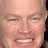

201 10	


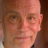

202 2	


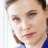

202 4	


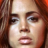

203 1	


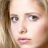

203 7	


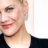

203 9	


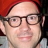

204 1	


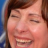

204 4	


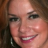

204 7	


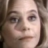

205 1	


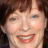

205 2	


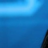

205 4	


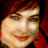

205 5	


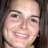

205 7	


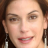

206 2	


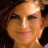

206 6	


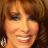

206 7	


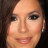

In [ ]:
parallel = parallel:cuda()
clusterSize = 0
correct = 0
avgDist = 0

imgSize = 120


function print_scaled_image(img)
	itorch.image(image.scale(img, 48, 48))
end

--batch size 10
local rand_num1 = 2 --number between 1 and trainBatches
local rand_num2 = 7 --number between 1 and 10
local randbatch = data.getBatch(rand_num1, 'train')
local test_img = randbatch[1][rand_num2] --can change rand_num2 and 1 to find good anchor
print_scaled_image(test_img)

--get the test_img embedding
local resize_inputs = {torch.Tensor(batchSize, 3, imgSize, imgSize),
	torch.Tensor(batchSize, 3, imgSize, imgSize),
	torch.Tensor(batchSize, 3, imgSize, imgSize)}

for apn = 1, 3 do
	for imgN = 1, batchSize do
		resize_inputs[apn][imgN] = image.scale(randbatch[apn][imgN], imgSize, imgSize)
	end
end
--print('pass')
aImgs = resize_inputs[1]
-- Positive training samples/images
pImgs = resize_inputs[2]
-- Negative training samples/images
nImgs = resize_inputs[3]

local inputs = {aImgs, pImgs, nImgs}
predict = parallel:forward({aImgs:cuda(), pImgs:cuda(), nImgs:cuda()})
test_img_emb = predict[1][rand_num2]

--threshold from panda histogram
local threshold = 0.61085965 --more conservative threshold is 0.34

local file = io.open("clusterdist_" .. tostring(rand_num1) .. "_" .. tostring(rand_num2) .. ".txt", "a")
for i = 1, trainBatches do
        --print(i .. " " .. trainBatches)
        local inputs = data.getBatch(i, 'train')
        local resize_inputs = {torch.Tensor(batchSize, 3, imgSize, imgSize),
            torch.Tensor(batchSize, 3, imgSize, imgSize),
            torch.Tensor(batchSize, 3, imgSize, imgSize)}

        for apn = 1, 3 do
            for imgN = 1, batchSize do
                resize_inputs[apn][imgN] = image.scale(inputs[apn][imgN], imgSize, imgSize)
            end
        end
        --print('pass')
        aImgs = resize_inputs[1]
        -- Positive training samples/images
        pImgs = resize_inputs[2]
        -- Negative training samples/images
        nImgs = resize_inputs[3]
        
        local inputs = {aImgs, pImgs, nImgs}
        predict = parallel:forward({aImgs:cuda(), pImgs:cuda(), nImgs:cuda()})
       
        for batchN = 1, batchSize do
            local anchor_test = computeSimilarity(predict[2][batchN], test_img_emb)
            if (anchor_test <= threshold) then
                clusterSize = clusterSize + 1
				avgDist = avgDist + anchor_test
				file:write(('%.6f\n'):format(anchor_test))
                print(i .. " " .. batchN)
                --print(anchor_test)
                print_scaled_image(inputs[1][batchN])
				--file:flush()
            end
           
        end

end

avgDist = avgDist/clusterSize
print("Total clusterSize: " .. clusterSize)
print("Average distance for similar images: " .. avgDist)

file:write("\nITotal clusterSize" .. clusterSize)
file:write("\nAverage distance for similar images: " .. avgDist)

file:close()